# Прогнозирование заказов такси

## Введение

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, **требуется построить прогностическую модель, предсказывающую количество заказов такси на следующий час.** Значение метрики *RMSE* на тестовой выборке должно быть не больше 48. 

**Описание данных:** 

- Датасет: `taxi.csv`.

- Целевая переменная: количество заказов в столбце `num_orders`. 


**План проекта:**

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке.
5. Сделать общий и промежуточные выводы.

## Подготовка

In [1]:
# загружаем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn import svm
from sklearn.svm import SVR
from catboost import CatBoostRegressor
 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

# задаем константы 
RAND_ST = 12345 

Хронологический ли порядок расположения дат: True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


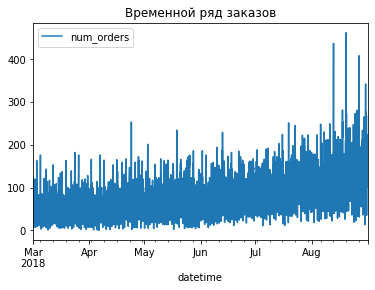

In [2]:
# загружаем датасет, определяя индексы и приводя тип к дате  
data = pd.read_csv('/Volumes/Datasets/datasets/taxi.csv', index_col=[0], parse_dates=[0])

# сортируем индексы
data.sort_index(inplace=True)

# проводим ресемплирование по 1 часу
data = data.resample('1H').sum()

# проверяем хронологический порядок расположения дат  
print('Хронологический ли порядок расположения дат:', data.index.is_monotonic)

# выводим инфо 
data.info()

# строим график
data.plot(title='Временной ряд заказов');

### Вывод
- Данные загрузили, заменили индексы на дату, проверили хронологию дат, провели ресемплирование по 1 часу и построили график среднего количества заказов в час. 

## Анализ

- Пропущенных значений в данных нет. Выведем основные статистические сведения. 

In [3]:
# смотрим распределение значений 
data['num_orders'].value_counts(normalize=True)

73     0.014719
66     0.013134
57     0.013134
78     0.012228
84     0.011775
         ...   
210    0.000226
214    0.000226
238    0.000226
242    0.000226
295    0.000226
Name: num_orders, Length: 251, dtype: float64

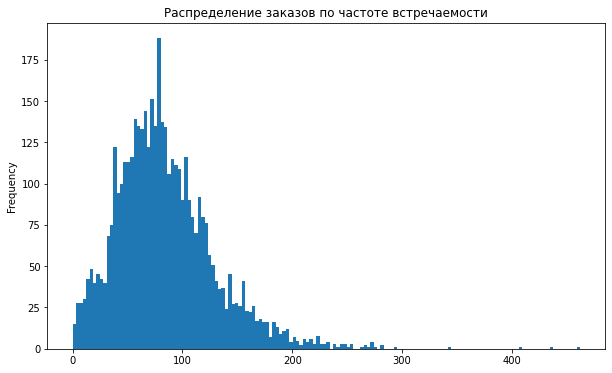

In [4]:
# смотрим распределение значений по частоте встречаемости
plt.figure(figsize=(10,6)) 
data['num_orders'].plot(bins=150, 
                        kind='hist')
plt.title("Распределение заказов по частоте встречаемости")
plt.show()

In [5]:
# смотрим статистики
data['num_orders'].describe()

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

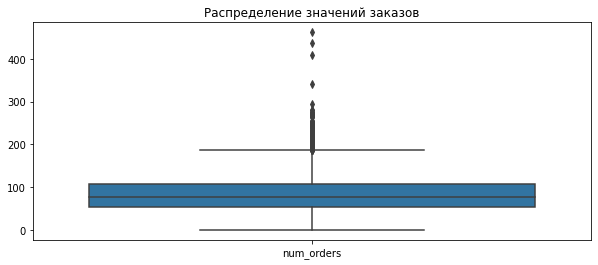

In [6]:
# смотрим выбросы
plt.figure(figsize=(10, 4))
sns.boxplot(data=data)
plt.title('Распределение значений заказов')
plt.show() 

- Самое частое количество заказов в час - 73. Наименее частое - 295. 

- Данные распределены нормально. 

- Стандартное отклонение невелико. Медиана почти совпадает со средним.

- Есть незначительное количество выбросов после значения в 200 заказов. 

- Построим графики с разным интервалом ресемплирования.

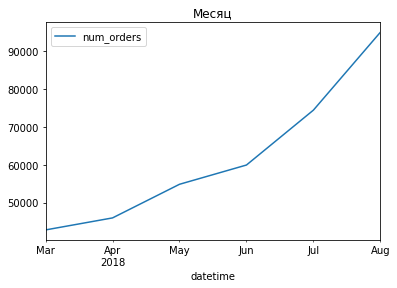

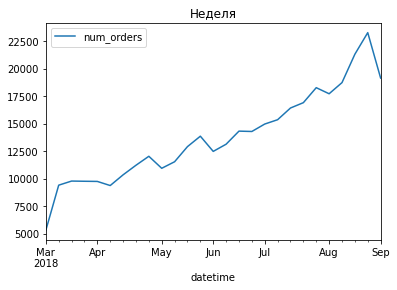

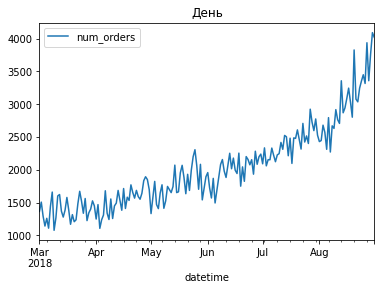

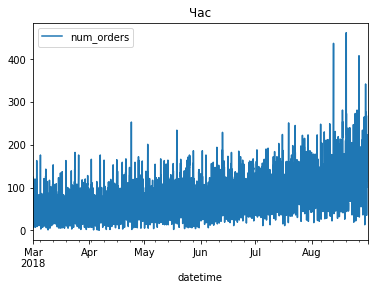

In [7]:
# задаем интервалы
interval_list = {"Месяц":'1M', 
                 "Неделя":'1W',
                 "День":'1D', 
                 "Час": '1H'}   

# строим графики 
def resample_plot(data):

    for n,i in interval_list.items():
        df = data.resample(i).sum()
        df.plot(title=n); 
            
resample_plot(data)       

- Временные кривые имеют явный восходящий тренд и неопределенную пока в рамках одного года сезонность. Проверим на других графиках.  

- Построим графики тренда и сезонности в интервале двое суток.

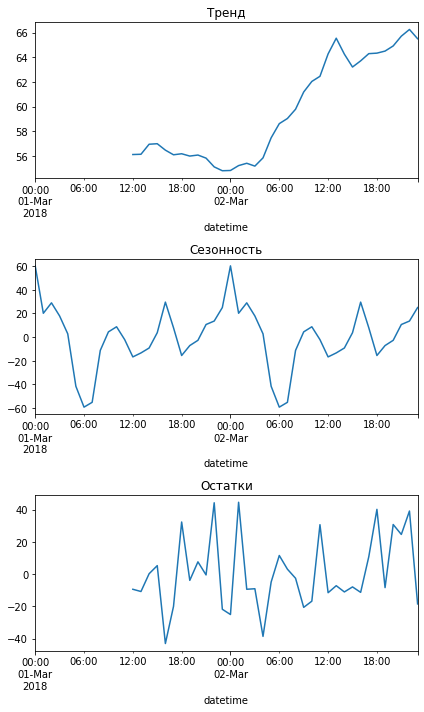

In [8]:
# декомпозируем таблицу
decomposed = seasonal_decompose(data)

# задаем интервал 
start = '2018-03-01'
stop = '2018-03-02'

# строим графики
plt.figure(figsize=(6,10))

plt.subplot(311)
decomposed.trend[start:stop].plot(ax=plt.gca())# получаем корректные текущие оси
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal[start:stop].plot(ax=plt.gca())
plt.title('Сезонность')

plt.subplot(313)
decomposed.resid[start:stop].plot(ax=plt.gca())
plt.title('Остатки')

plt.tight_layout()

- Количество заказов в течение суток растет и имеет минимум в 6 часов, а максимум - в 24 часа. Остатки почти скачкообразны и некоррелируемы на всем протяжении выборки.

- Посмотрим на скользящее среднее за весь период и в интервале 15 дней середины периода наблюдений. 

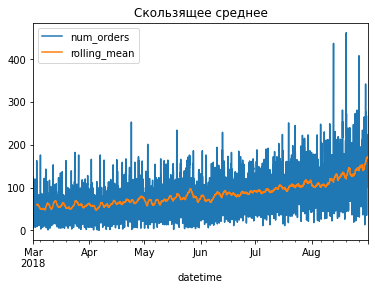

In [9]:
# задаем интервал 
df = data.resample('1H').sum()

# задаем размер окна в 48 часов без учета текущего значения и строим график 
df['rolling_mean'] = df.shift().rolling(48).mean()

df.plot(figsize=(6,4), title='Скользящее среднее');

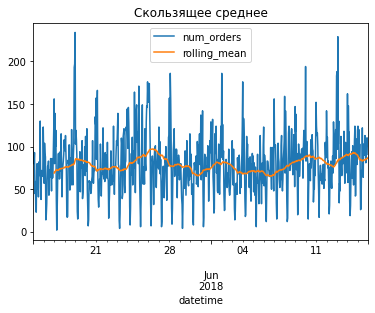

In [10]:
# задаем интервал 
df = data['2018-05-15':'2018-06-15'].resample('1H').sum()

# задаем размер окна в 48 часов без учета текущего значения и строим график 
df['rolling_mean'] = df.shift().rolling(48).mean()

df.plot(figsize=(6,4), title='Скользящее среднее');

- Среднее количество заказов в течение двух выбранных из середины периода недель наблюдений находится в пределах 60-80. От месяца к месяцу эта величина растет.

- Проверим наш временной ряд на стационарность.

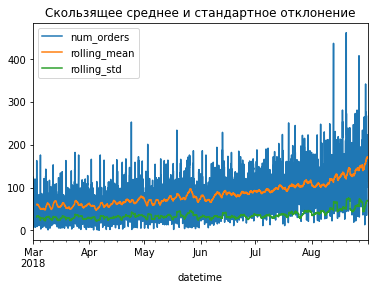

In [11]:
# задаем интервал 
df = data.resample('1H').sum()

# задаем размер окна в 48 часов без учета текущего значения и строим график 
df['rolling_mean'] = df.shift().rolling(48).mean()
df['rolling_std'] = df['num_orders'].shift().rolling(48).std()

df.plot(figsize=(6,4), title='Скользящее среднее и стандартное отклонение');

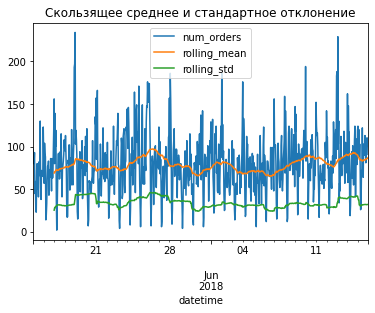

In [12]:
# задаем интервал 
df = data['2018-05-15':'2018-06-15'].resample('1H').sum()

# задаем размер окна в 48 часов без учета текущего значения и строим график 
df['rolling_mean'] = df.shift().rolling(48).mean()
df['rolling_std'] = df['num_orders'].shift().rolling(48).std()

df.plot(figsize=(6,4), title='Скользящее среднее и стандартное отклонение');

- Ряд скорее стационарный, так как стандартное отклонение в течение всего периода почти не меняется. 

- Чтобы удостовериться в стационарности временного ряда, проведем тест Дики-Фуллера.

  - Нулевая гипотеза H0: g = 0 (существуют единичные корни, ряд нестационарный). 
  - Альтернативная гипотеза: H1: g < 0 (единичных корней нет, ряд стационарный).
  - Если  p-value окажется ниже 5% - ряд стационарный. 

In [13]:
# активизируем тест
test = adfuller(data)

# выводим результаты
print('ADF: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical values:')
for key, value in test[4].items():
    print('\t%s: %.3f' % (key, value))
if test[0] > test[4]['5%']:
    print('Единичные корни есть, ряд не стационарен.')
else:
    print('Единичных корней нет, ряд стационарен.')    

ADF: -3.068924
p-value: 0.028940
Critical values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Единичных корней нет, ряд стационарен.


### Вывод

- Провели анализ данных, построили графики тренда, сезонности, скользящего среднего и вывели основные статистики, посмотрели выбросы.

- Проверили ряд на стационарность: ряд стационарен.  


- Переходим к обучению. 

## Обучение

- Создадим признаки:

  - Календарные значения: час, день недели.
  - Отстающие значения.
  - Скользящее среднее.

In [14]:
# создаем функцию генерации признаков
def make_features(data, max_lag, rolling_mean_size):
    
    # календарные признаки  
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    # отстающие значения
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    # скользящее среднее без учета текущего значения 
    data['rolling_mean'] =\
    data['num_orders'].shift().rolling(rolling_mean_size).mean()

# задаем параметры     
make_features(data, 15, 15)

# проверяем
data.head()

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Разделим данные на обучающую и тестовую выборки. Размер тестовой выборки сделаем 10% от всех данных. В тренировочной выборке удалим пропуски.

In [15]:
# формируем выборки: обучающую(90%) и тестовую(10%)
train, test = train_test_split(data, 
                               shuffle=False, 
                               test_size=0.1,
                               random_state=RAND_ST)

# удаляем пропуски в тренировочной выборке
train = train.dropna()

# выделяем цель и признаки
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

# проверяем
print('Тренировочная выборка:\n', 
      X_train.shape, train.index.min(), train.index.max())
print(y_train.shape)
print('Тестовая выборка:\n', 
      X_test.shape, test.index.min(), test.index.max())
print(y_test.shape)

Тренировочная выборка:
 (3959, 18) 2018-03-01 15:00:00 2018-08-13 13:00:00
(3959,)
Тестовая выборка:
 (442, 18) 2018-08-13 14:00:00 2018-08-31 23:00:00
(442,)


- Проведем обучение.


- Для работы выберем пять моделей:

     - LinearRegression.
     - RandomForestRegressor.
     - LGBMRegressor.
     - Epsilon-Support Vector Regression (SVR).
     - CatBoostRegressor.

- Чтобы корректно провести кросс-валидацию, используем TimeSeriesSplit.

In [16]:
# создаем объект TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

In [17]:
# создаем функцию работы кросс-валидатора
def cross_val_score(estimator, parametrs, features, target):
    
    # активируем поиск и запускаем обучение
    model = HalvingRandomSearchCV(estimator=estimator,
                                  param_distributions=parametrs,
                                  cv=tscv,
                                  n_jobs=-1,
                                  factor=2,
                                  max_resources=80,
                                  scoring='neg_root_mean_squared_error',
                                  random_state=RAND_ST,
                                  verbose=1)

    model.fit(features, target)
    
    # сохраняем лучшую модель и лучшую оценку
    best_model = estimator.set_params(**model.best_params_)
    best_rmse = abs(round(model.best_score_, 3))
    
    # выводим лучшие гиперпараметры и оценку
    print() 
    print(f'Best RMSE: {best_rmse}')
    print(f'Best params: {model.best_params_}')

    return best_model, best_rmse

- Сведем результаты работы моделей в одну таблицу.

In [18]:
# создаем таблицу с результатами работы моделей
results_df = pd.DataFrame(columns=['Model', 'RMSE_train'])

In [19]:
%%time
# подбираем гиперпараметры для Линейной регрессии

# задаем область поиска гиперпараметров
parametrs =  { 'n_jobs': [1, -1],
              'fit_intercept': [True, False],
              'copy_X':[True, False]
              }

# активируем модель
model_LR_HCV, best_RMSE_HCV_LR = cross_val_score(LinearRegression(), 
                                                 parametrs, 
                                                 X_train, y_train 
                                                )

# добавляем результат кросс-валидации в таблицу
results_df.loc[0] = ['LinearRegression', best_RMSE_HCV_LR]

results_df

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 20
max_resources_: 80
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 4
n_resources: 20
Fitting 10 folds for each of 4 candidates, totalling 40 fits
----------
iter: 1
n_candidates: 2
n_resources: 40
Fitting 10 folds for each of 2 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 1
n_resources: 80
Fitting 10 folds for each of 1 candidates, totalling 10 fits

Best RMSE: 50.275
Best params: {'n_jobs': 1, 'fit_intercept': True, 'copy_X': True}
CPU times: user 352 ms, sys: 140 ms, total: 492 ms
Wall time: 2.92 s


,Model,RMSE_train
0,LinearRegression,50.275


In [20]:
%%time
# подбираем гиперпараметры для Случайного леса

# задаем область поиска гиперпараметров
parametrs = {'n_estimators': range(100, 350, 50), 
             'max_depth': range(1, 12)             
            }

# активируем модель
model_RFR_HCV, best_RMSE_HCV_RFR = cross_val_score(RandomForestRegressor(random_state=RAND_ST), 
                                                   parametrs, 
                                                   X_train, 
                                                   y_train 
                                                  )

# добавляем результат в таблицу
results_df.loc[1] = ['RandomForestRegressor', best_RMSE_HCV_RFR]

results_df.sort_values(by='RMSE_train')

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 20
max_resources_: 80
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 4
n_resources: 20
Fitting 10 folds for each of 4 candidates, totalling 40 fits
----------
iter: 1
n_candidates: 2
n_resources: 40
Fitting 10 folds for each of 2 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 1
n_resources: 80
Fitting 10 folds for each of 1 candidates, totalling 10 fits

Best RMSE: 35.614
Best params: {'n_estimators': 100, 'max_depth': 9}
CPU times: user 3.29 s, sys: 78.7 ms, total: 3.37 s
Wall time: 12 s


,Model,RMSE_train
1,RandomForestRegressor,35.614
0,LinearRegression,50.275


In [21]:
%%time
# подбираем гиперпараметры для LGBMRegressor

# задаем область поиска гиперпараметров
parametrs = {'max_depth':  range(1,8),
             'learning_rate': [0.1, 0.3, 0.5],
             'n_estimators': range(100, 600, 100)
            }

# активируем модель
model_LGBMR_HCV, best_RMSE_HCV_LGBMR = cross_val_score(LGBMRegressor(random_state=RAND_ST), 
                                                       parametrs, 
                                                       X_train, 
                                                       y_train 
                                                      )

# добавляем результат в таблицу
results_df.loc[2] = ['LGBMRegressor', best_RMSE_HCV_LGBMR]

results_df.sort_values(by='RMSE_train')

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 20
max_resources_: 80
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 4
n_resources: 20
Fitting 10 folds for each of 4 candidates, totalling 40 fits
----------
iter: 1
n_candidates: 2
n_resources: 40
Fitting 10 folds for each of 2 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 1
n_resources: 80
Fitting 10 folds for each of 1 candidates, totalling 10 fits

Best RMSE: 36.486
Best params: {'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.3}
CPU times: user 1.17 s, sys: 83.4 ms, total: 1.26 s
Wall time: 1.4 s


,Model,RMSE_train
1,RandomForestRegressor,35.614
2,LGBMRegressor,36.486
0,LinearRegression,50.275


In [22]:
%%time
# подбираем гиперпараметры для SVR

# задаем область поиска гиперпараметров
parametrs = {'C': [0.1, 0.3, 0.5, 1.0],
             'epsilon': [0.1, 0.5, 1.0]}

# активируем модель
model_SVR_HCV, best_RMSE_HCV_SVR = cross_val_score(svm.SVR(
                                                   verbose=False 
                                                           ), 
                                                    parametrs, 
                                                    X_train, 
                                                    y_train 
                                                   )

# добавляем результат в таблицу
results_df.loc[3] = ['SVR', best_RMSE_HCV_SVR]

results_df.sort_values(by='RMSE_train')

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 20
max_resources_: 80
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 4
n_resources: 20
Fitting 10 folds for each of 4 candidates, totalling 40 fits
----------
iter: 1
n_candidates: 2
n_resources: 40
Fitting 10 folds for each of 2 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 1
n_resources: 80
Fitting 10 folds for each of 1 candidates, totalling 10 fits

Best RMSE: 34.728
Best params: {'epsilon': 0.1, 'C': 0.3}
CPU times: user 1.28 s, sys: 121 ms, total: 1.4 s
Wall time: 1.57 s


,Model,RMSE_train
3,SVR,34.728
1,RandomForestRegressor,35.614
2,LGBMRegressor,36.486
0,LinearRegression,50.275


In [23]:
%%time
# подбираем гиперпараметры для CatBoostRegressor

# задаем область поиска гиперпараметров
parametrs = {'iterations': range(100, 600, 100),
             'depth':  range(1,8),
             'learning_rate': [0.1, 0.3]
            }

# активируем модель
model_CBR_HCV, best_RMSE_HCV_CBR = cross_val_score(CatBoostRegressor(
                                                    random_state=RAND_ST,
                                                    verbose=False, 
                                                    allow_const_label=True
                                                                     ), 
                                                    parametrs, 
                                                    X_train, 
                                                    y_train 
                                                   )

# добавляем результат в таблицу
results_df.loc[4] = ['CatBoostRegressor', best_RMSE_HCV_CBR]

results_df.sort_values(by='RMSE_train')

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 20
max_resources_: 80
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 4
n_resources: 20
Fitting 10 folds for each of 4 candidates, totalling 40 fits
----------
iter: 1
n_candidates: 2
n_resources: 40
Fitting 10 folds for each of 2 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 1
n_resources: 80
Fitting 10 folds for each of 1 candidates, totalling 10 fits

Best RMSE: 34.514
Best params: {'learning_rate': 0.3, 'iterations': 200, 'depth': 7}
CPU times: user 3.24 s, sys: 249 ms, total: 3.48 s
Wall time: 8.44 s


,Model,RMSE_train
4,CatBoostRegressor,34.514
3,SVR,34.728
1,RandomForestRegressor,35.614
2,LGBMRegressor,36.486
0,LinearRegression,50.275


### Вывод

- Обучили несколько моделей и получили их лучшие оценки на кросс-валидации, подобрав лучшие гиперпараметры. 


- Лучший показатель - у CatBoostRegressor.


- LinearRegression явно недоучилась. Остальные модели, возможно, переучились.  

- Проверим работу лучшей модели на тестовой выборке.

## Тестирование

In [24]:
# создаем функцию работы модели
def ML_score_test(model, features, target):
    
    # обучаем на обучающей выборке
    model.fit(X_train, y_train)
    
    # получаем предсказание
    predicted = model.predict(features)
    
    # считаем метрики 
    RMSE = round(mean_squared_error(target, predicted, squared=False),3)
    MAE = round(mean_absolute_error(target, predicted),3)
    
    return RMSE, MAE, predicted

In [25]:
# получаем предсказание CatBoostRegressor
RMSE_test_CBR, MAE_test_CBR, predict_CBR = ML_score_test(model_CBR_HCV,
                                                         X_test, 
                                                         y_test)

# выводим результаты
print(f"RMSE CatBoostRegressor тестовой выборки : {RMSE_test_CBR} ")
print(f"MAE CatBoostRegressor тестовой выборки: {MAE_test_CBR} ")
print(f"Среднее предсказанное количество заказов в час: {round(predict_CBR.mean(),3)}")

RMSE CatBoostRegressor тестовой выборки : 44.924 
MAE CatBoostRegressor тестовой выборки: 33.78 
Среднее предсказанное количество заказов в час: 123.748


- Построим график сравнения фактического и предсказанного CatBoostRegressor количества заказов в час. 

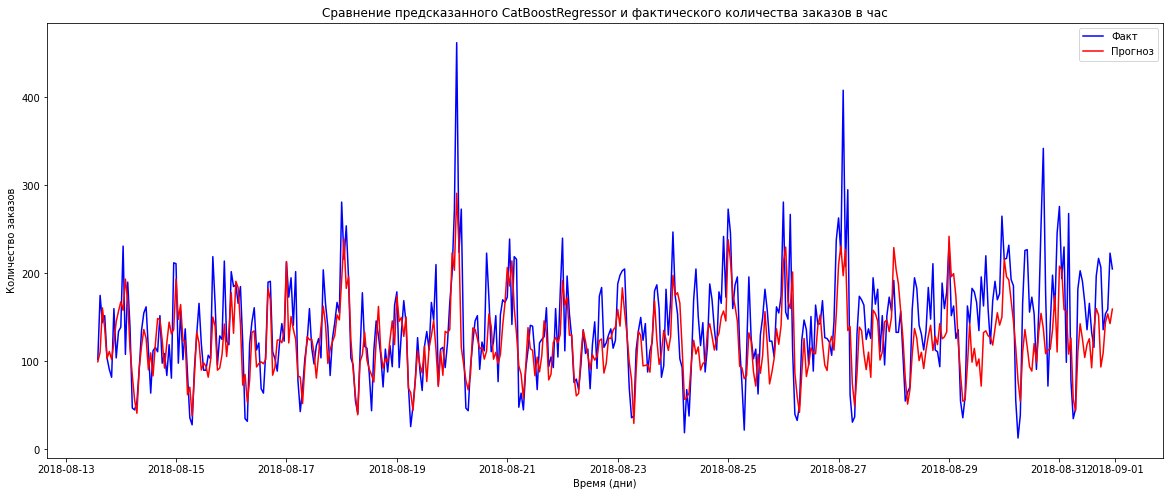

In [26]:
# строим график 
fig, ax = plt.subplots(figsize=[20,8])
plt.title('Сравнение предсказанного CatBoostRegressor и фактического количества заказов в час')
plt.plot(y_test.index, 
         y_test,
         'b-',
        label='Факт')

plt.plot(y_test.index, 
         predict_CBR,
         'r-',
        label='Прогноз')

ax.legend()
plt.xlabel('Время (дни)')
plt.ylabel('Количество заказов')
plt.show()  

- Проверим модель на адекватность, используя два способа:

  - Константой (средним и медианой).
  
  - Предыдущим значением ряда.

In [27]:
# выводим среднее значение целевой переменной 
test_mean = round(y_test.mean(),3)
print("Среднее количество заказов в час:", test_mean)
print()

# проверяем адекватность константой
pred_median = np.ones(y_test.shape) * y_train.median()
pred_mean = np.ones(y_test.shape) * y_train.mean()

RMSE_const = round(mean_squared_error(y_test, pred_mean, squared=False),3)
MAE_const = round(mean_absolute_error(y_test, pred_median),3)

print("RMSE_const:", RMSE_const)
print("MAE_const:", MAE_const)
print()

# проверяем адекватность предыдущим значением
pred_previous = y_test.shift(fill_value = y_train.iloc[-1])

RMSE_shift = round(mean_squared_error(y_test, pred_previous, squared=False),3)
MAE_shift = round(mean_absolute_error(y_test, pred_previous),3)

print("RMSE_shift:", RMSE_shift)
print("MAE_shift:", MAE_shift)

Среднее количество заказов в час: 139.557

RMSE_const: 84.675
MAE_const: 70.792

RMSE_shift: 58.856
MAE_shift: 44.973


- Судя по тесту, модель вполне адекватна. 

### Вывод

- Получили предсказание лучшей модели - CatBoostRegressor - на тестовой выборке. Среднее предсказанное количество заказов на следующий час составляет примерно 124.  Значение метрики RMSE  - 44.924. Модель немного переучилась. 

## Общий вывод


- **В процессе работы над проектом мы:**

  - Загрузили данные и выполнили их ресемплирование по одному часу;
  - Проанализировали данные;
  - Обучили разные модели: LinearRegression, RandomForestRegressor, LGBMRegressor, Epsilon-Support Vector Regression (SVR) и CatBoostRegressor. Для каждой модели попробовали разные гиперпараметры;
  - Проверили качество лучшей модели на тестовой выборке и проверили модель на адекватность;
  - Сделали общий и промежуточные выводы.
  
**Резюме:**

**Лучше других** с задачей справилась **модель CatBoostRegressor**, показав лучшее качество предсказания на тестовой выборке (**RMSE на тесте = 44.924**). Модель можно рекомендовать сервису.